In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU , InputLayer , Dense
import tensorflow as tf
from datetime import datetime
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import callbacks
from kerastuner.tuners import RandomSearch
import keras_tuner as kt


<ipython-input-2-5a8fbd010de4>:19: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
dataset = read_csv("/content/Mangalore.csv")
dataset.fillna(0, inplace=True)
values = dataset.values
# ensure all data is float
# values = dataset.values.astype('float32')
# dataset.drop(columns = ['time','si10'],inplace = True)

In [ ]:
dataset.head(5)

,Date/time [UTC],Speed_50m [m/s]
0,1980-01-01T00:00:00,2.90
1,1980-01-01T01:00:00,3.66
2,1980-01-01T02:00:00,3.74
3,1980-01-01T03:00:00,3.72
4,1980-01-01T04:00:00,3.52


In [ ]:
import pandas as pd

# Assuming df is your DataFrame
dataset = dataset.drop(dataset.columns[0], axis=1)


In [ ]:
# Assuming df is your DataFrame
dataset = dataset.rename(columns={dataset.columns[0]: 'speed'})


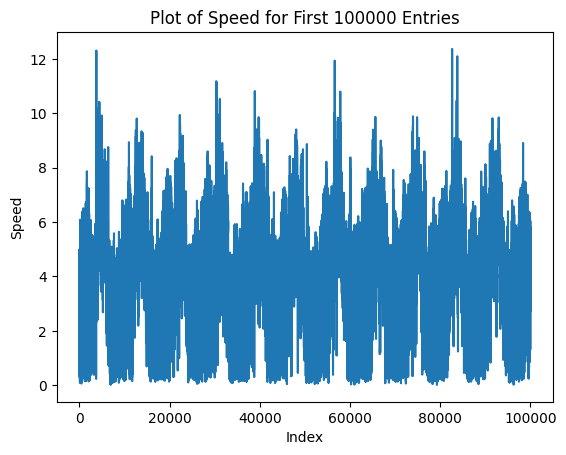

In [ ]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'speed' is the column you want to plot
plt.plot(dataset['speed'].iloc[:100000])
plt.xlabel('Index')
plt.ylabel('Speed')
plt.title('Plot of Speed for First 100000 Entries')
plt.show()


In [ ]:
dataset.head()

,speed
0,2.90
1,3.66
2,3.74
3,3.72
4,3.52


In [ ]:
dataset.shape

(336744, 1)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
# numerical_columns = ['horizontal', 'vertical', 'si10', 'temperature', 'precipitation']
scaled = scaler.fit_transform(dataset)
scaled =pd.DataFrame(scaled)

In [ ]:
dataset = scaled
dataset.head()

,0
0,0.222137
1,0.280553
2,0.286703
3,0.285165
4,0.269792


In [ ]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [a for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(dataset, WINDOW_SIZE)
X1.shape, y1.shape

((336739, 5, 1), (336739, 1))

In [ ]:
X3_train, y3_train = X1[:250000], y1[:250000]
X3_val, y3_val = X1[250001:300000], y1[250001:300000]
X3_test, y3_test = X1[300001:], y1[300001:]
X3_train.shape, y3_train.shape, X3_val.shape, y3_val.shape, X3_test.shape, y3_test.shape

((250000, 5, 1),
 (250000, 1),
 (49999, 5, 1),
 (49999, 1),
 (36738, 5, 1),
 (36738, 1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((X3_train.shape[1], X3_train.shape[2])))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [ ]:
# model_checkpoint10 = ModelCheckpoint('best_model10.h5', monitor='val_loss', save_best_only=True)

In [ ]:
# model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
# history = model1.fit(X3_train, y3_train, epochs=2, validation_data=(X3_val, y3_val), callbacks=[early_stopping,model_checkpoint10])

**LSTM MODEL**

In [ ]:
def build_model5(hp):
    model = Sequential()
    model.add(InputLayer((X3_train.shape[1],X3_train.shape[2])))

    # Number of LSTM layers
    lstm_layers = hp.Int('lstm_layers', min_value=1, max_value=3, step=1)

    # Add LSTM layers
    for i in range(lstm_layers):
        units = hp.Int(f'units_{i}', min_value=32, max_value=128, step=8)
        return_sequences = True if i < lstm_layers - 1 else False  # return sequences for all but last layer
        model.add(LSTM(units=units, return_sequences=return_sequences))

    # Number of dense layers
    dense_layers = hp.Int('dense_layers', min_value=1, max_value=3, step=1)

    # Add dense layers
    for i in range(dense_layers):
        units = hp.Int(f'dense_units_{i}', min_value=32, max_value=128, step=8)
        model.add(Dense(units, 'relu'))

    model.add(Dense(1, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
    return model


In [ ]:
tuner = RandomSearch(
    build_model5,
    kt.Objective("val_root_mean_squared_error", direction="min"),
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir15',
    project_name='lstm_hyperparameter_tuning3'
)


In [ ]:
tuner.search(X3_train, y3_train, epochs=10, validation_data=(X3_val, y3_val))

Trial 5 Complete [00h 11m 37s]
val_root_mean_squared_error: 0.017518028616905212

Best val_root_mean_squared_error So Far: 0.017150407657027245
Total elapsed time: 01h 01m 00s


In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp

In [ ]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model_checkpoint9 = ModelCheckpoint('best_model9.keras', monitor='val_loss', save_best_only=True)

In [ ]:
best_model = tuner.hypermodel.build(best_hp)

In [ ]:
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 5, 40)               │          27,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 80)                  │          38,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 112)                 │           9,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 96)                  │          10,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 56)                  │           5,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              57 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,729 (616.13 KB)

 Trainable params: 157,729 (616.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = best_model.fit(X3_train, y3_train, epochs=100, validation_data=(X3_val, y3_val), callbacks=[early_stopping,model_checkpoint9])

Epoch 1/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 70s 9ms/step - loss: 0.0085 - root_mean_squared_error: 0.0845 - val_loss: 4.9441e-04 - val_root_mean_squared_error: 0.0222
Epoch 2/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 65s 8ms/step - loss: 4.0050e-04 - root_mean_squared_error: 0.0200 - val_loss: 3.1715e-04 - val_root_mean_squared_error: 0.0178
Epoch 3/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 69s 9ms/step - loss: 3.5645e-04 - root_mean_squared_error: 0.0189 - val_loss: 3.1346e-04 - val_root_mean_squared_error: 0.0177
Epoch 4/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 66s 8ms/step - loss: 3.4370e-04 - root_mean_squared_error: 0.0185 - val_loss: 3.4033e-04 - val_root_mean_squared_error: 0.0184
Epoch 5/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - loss: 3.3677e-04 - root_mean_squared_error: 0.0184 - val_loss: 3.1431e-04 - val_root_mean_squared_error: 0.0177
Epoch 6/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 65s 8ms/step - loss: 3.3183e-04 - root_mean_squared_error: 0.0182 - val_loss: 3.1051e-04 - val_root_mean_square

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score

def plot_predictions2(model, X, y, start=0, end=100):
    predictions = model.predict(X)
    hor_preds = predictions[:, 0]
    hor_actuals = y[:, 0]
    df = pd.DataFrame(data={'Hor Predictions': hor_preds,
                            'Hor Actuals': hor_actuals,
                            })
    plt.plot(df['Hor Predictions'][start:end], label='Predictions')
    plt.plot(df['Hor Actuals'][start:end], label='Actuals')
    plt.legend()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(hor_actuals, hor_preds))
    print(f"RMSE: {rmse}")

    # Calculate MSE
    mse = mean_squared_error(hor_actuals, hor_preds)
    print(f"MSE: {mse}")

    # Calculate MAE
    mae = mean_absolute_error(hor_actuals, hor_preds)
    print(f"MAE: {mae}")

    # Calculate R-squared
    r2 = r2_score(hor_actuals, hor_preds)
    print(f"R-squared: {r2}")

    # Calculate MAPE
    mape = mean_absolute_percentage_error(hor_actuals, hor_preds)
    print(f"MAPE: {mape}")

    # Calculate MASE (assuming horizons are consecutive time steps)
    naive_error = np.mean(np.abs(hor_actuals[1:] - hor_actuals[:-1]))
    mase = mae / naive_error
    print(f"MASE: {mase}")

    # Calculate Explained Variance Score
    explained_variance = explained_variance_score(hor_actuals, hor_preds)
    print(f"Explained Variance Score: {explained_variance}")

    return df[start:end]


1149/1149 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
RMSE: 0.01700055969999754
MSE: 0.0002890190301131805
MAE: 0.012212858098499741
R-squared: 0.9828535576161258
MAPE: 0.07148173816160672
MASE: 0.490061743132744
Explained Variance Score: 0.9829357992883082


,Hor Predictions,Hor Actuals
0,0.194989,0.204458
1,0.270652,0.274404
2,0.333687,0.350500
3,0.410763,0.392006
4,0.387878,0.402767
...,...,...
95,0.156887,0.177556
96,0.192539,0.197540
97,0.223125,0.250576
98,0.302416,0.322060


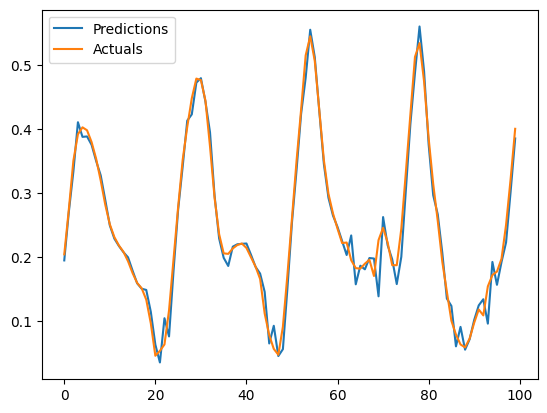

In [ ]:
best_model93 = tf.keras.models.load_model('best_model9.keras')

plot_predictions2(best_model93, X3_test, y3_test)

Minimum validation loss: 0.0002847083087544888


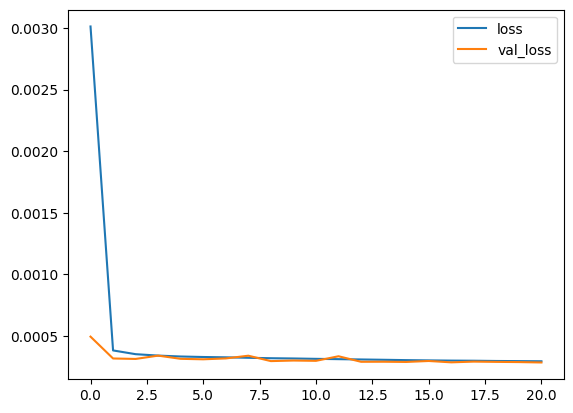

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

1149/1149 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
RMSE: 0.01700055969999754
MSE: 0.0002890190301131805
MAE: 0.012212858098499741
R-squared: 0.9828535576161258
MAPE: 0.07148173816160672
MASE: 0.490061743132744
Explained Variance Score: 0.9829357992883082


,Hor Predictions,Hor Actuals
0,0.194989,0.204458
1,0.270652,0.274404
2,0.333687,0.350500
3,0.410763,0.392006
4,0.387878,0.402767
...,...,...
95,0.156887,0.177556
96,0.192539,0.197540
97,0.223125,0.250576
98,0.302416,0.322060


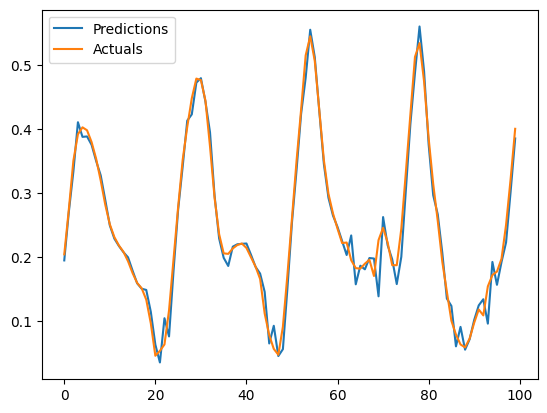

In [ ]:
plot_predictions2(best_model93, X3_test, y3_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


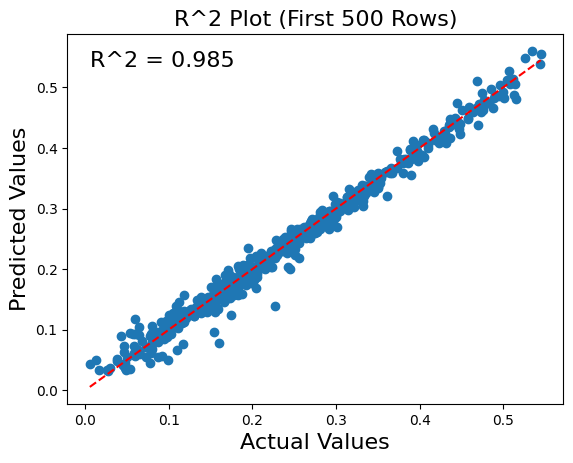

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Slice the test data to include only the first 500 rows
y3_test_subset = y3_test[:500]
X3_test_subset = X3_test[:500]

# Calculate the R^2 score
r2 = r2_score(y3_test_subset, best_model93.predict(X3_test_subset))

# Create a scatter plot of the actual vs predicted values
plt.scatter(y3_test_subset, best_model93.predict(X3_test_subset))

# Add a line for the perfect fit (R^2 = 1)
plt.plot([min(y3_test_subset), max(y3_test_subset)], [min(y3_test_subset), max(y3_test_subset)], 'r--')

# Add the R^2 score to the top left corner of the plot
plt.text(min(y3_test_subset), max(best_model93.predict(X3_test_subset)), f'R^2 = {r2:.3f}',
         fontsize=16, verticalalignment='top', horizontalalignment='left')

# Set the labels and title
plt.xlabel('Actual Values', fontsize=16)
plt.ylabel('Predicted Values', fontsize=16)
plt.title('R^2 Plot (First 500 Rows)', fontsize=16)

# Show the plot
plt.show()


**GRU MODEL**

In [ ]:
def build_model8(hp):
    model = Sequential()
    model.add(InputLayer((X3_train.shape[1], X3_train.shape[2])))

    # Number of GRU layers
    gru_layers = hp.Int('gru_layers', min_value=1, max_value=3, step=1)

    # Add GRU layers
    for i in range(gru_layers):
        units = hp.Int(f'units_{i}', min_value=32, max_value=128, step=8)
        return_sequences = True if i < gru_layers - 1 else False  # return sequences for all but last layer
        model.add(GRU(units=units, return_sequences=return_sequences))

    # Number of Dense layers
    dense_layers = hp.Int('dense_layers', min_value=1, max_value=3, step=1)

    # Add Dense layers
    for i in range(dense_layers):
        units = hp.Int(f'units_dense_{i}', min_value=32, max_value=128, step=8)
        activation = hp.Choice(f'activation_dense_{i}', values=['relu', 'sigmoid', 'tanh'])
        model.add(Dense(units, activation=activation))

    model.add(Dense(1, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
    return model

# Define the tuner
tuner = RandomSearch(
    build_model8,
    kt.Objective("val_root_mean_squared_error", direction="min"),
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='model9_hyperparameter_tuning'
)

# Generate the search space
tuner.search_space_summary()

# Perform the hyperparameter search
tuner.search(X3_train, y3_train, epochs=10, validation_data=(X3_val, y3_val))

Trial 5 Complete [00h 12m 44s]
val_root_mean_squared_error: 0.01751950941979885

Best val_root_mean_squared_error So Far: 0.0169794000685215
Total elapsed time: 00h 58m 10s


In [ ]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hp}")

# Build the best model
best_model10 = tuner.hypermodel.build(best_hp)

model_checkpoint3 = ModelCheckpoint('best_model5.keras', monitor='val_loss', save_best_only=True)

# Train the best model
best_model10.fit(X3_train, y3_train, epochs=100, validation_data=(X3_val, y3_val), callbacks=[early_stopping,model_checkpoint3])

Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7d427a3d07f0>
Epoch 1/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 66s 8ms/step - loss: 0.0067 - root_mean_squared_error: 0.0722 - val_loss: 3.7146e-04 - val_root_mean_squared_error: 0.0193
Epoch 2/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 62s 8ms/step - loss: 3.6239e-04 - root_mean_squared_error: 0.0190 - val_loss: 3.1648e-04 - val_root_mean_squared_error: 0.0178
Epoch 3/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 63s 8ms/step - loss: 3.4634e-04 - root_mean_squared_error: 0.0186 - val_loss: 3.1300e-04 - val_root_mean_squared_error: 0.0177
Epoch 4/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - loss: 3.3275e-04 - root_mean_squared_error: 0.0182 - val_loss: 3.2536e-04 - val_root_mean_squared_error: 0.0180
Epoch 5/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - loss: 3.3067e-04 - root_mean_squared_error: 0.0182 - val_loss: 3.0140e-04 - val_root_mean_squared_error: 0.0174
Epoch 6/100
7813/7813 ━━━━━━━━━━━━

In [ ]:
best_model10.fit(X3_train, y3_train, epochs=100, validation_data=(X3_val, y3_val), callbacks=[early_stopping,model_checkpoint3])

Epoch 1/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 61s 8ms/step - loss: 3.7245e-04 - root_mean_squared_error: 0.0193 - val_loss: 3.9658e-04 - val_root_mean_squared_error: 0.0199
Epoch 2/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 61s 8ms/step - loss: 3.4002e-04 - root_mean_squared_error: 0.0184 - val_loss: 3.4054e-04 - val_root_mean_squared_error: 0.0185
Epoch 3/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - loss: 3.2906e-04 - root_mean_squared_error: 0.0181 - val_loss: 3.1639e-04 - val_root_mean_squared_error: 0.0178
Epoch 4/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - loss: 3.2644e-04 - root_mean_squared_error: 0.0181 - val_loss: 3.1806e-04 - val_root_mean_squared_error: 0.0178
Epoch 5/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - loss: 3.2204e-04 - root_mean_squared_error: 0.0179 - val_loss: 3.0066e-04 - val_root_mean_squared_error: 0.0173
Epoch 6/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - loss: 3.2108e-04 - root_mean_squared_error: 0.0179 - val_loss: 3.0804e-04 - val_root_mean_sq

In [ ]:
best_model10.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                          │ (None, 5, 120)              │          44,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 5, 32)               │          14,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 32)                  │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,045 (828.30 KB)

 Trainable params: 70,681 (276.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 141,364 (552.21 KB)

1149/1149 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
RMSE: 0.01693792916125565
MSE: 0.0002868934442717145
MAE: 0.012273955296269576
R-squared: 0.9829796608528172
MAPE: 0.07321029319824655
MASE: 0.4925133723089881
Explained Variance Score: 0.9829821303147072


,Hor Predictions,Hor Actuals
0,0.189995,0.204458
1,0.267569,0.274404
2,0.329191,0.350500
3,0.413057,0.392006
4,0.383693,0.402767
...,...,...
95,0.157152,0.177556
96,0.187584,0.197540
97,0.221910,0.250576
98,0.302047,0.322060


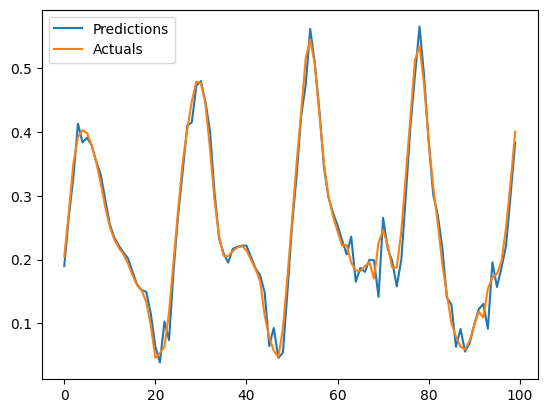

In [ ]:
# best_model10.summary()

best_model3 = tf.keras.models.load_model('best_model5.keras')

plot_predictions2(best_model3, X3_test, y3_test)

1149/1149 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


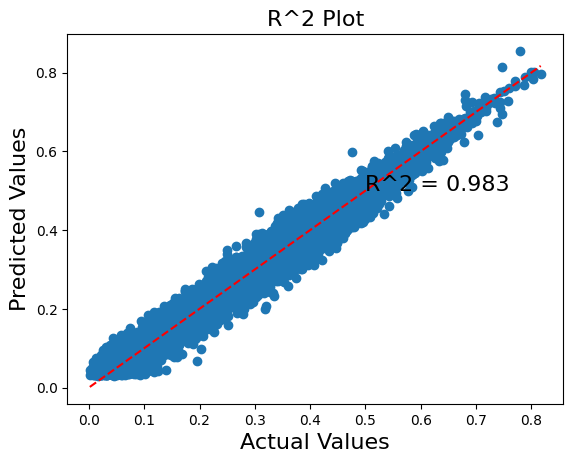

In [ ]:
import matplotlib.pyplot as plt

# Calculate the R^2 score
r2 = r2_score(y3_test, best_model3.predict(X3_test))

# Create a scatter plot of the actual vs predicted values
plt.scatter(y3_test, best_model3.predict(X3_test))

# Add a line for the perfect fit (R^2 = 1)
plt.plot([min(y3_test), max(y3_test)], [min(y3_test), max(y3_test)], 'r--')

# Add the R^2 score to the plot
plt.text(0.5, 0.5, f'R^2 = {r2:.3f}', fontsize=16)

# Set the labels and title
plt.xlabel('Actual Values', fontsize=16)
plt.ylabel('Predicted Values', fontsize=16)
plt.title('R^2 Plot', fontsize=16)

# Show the plot
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


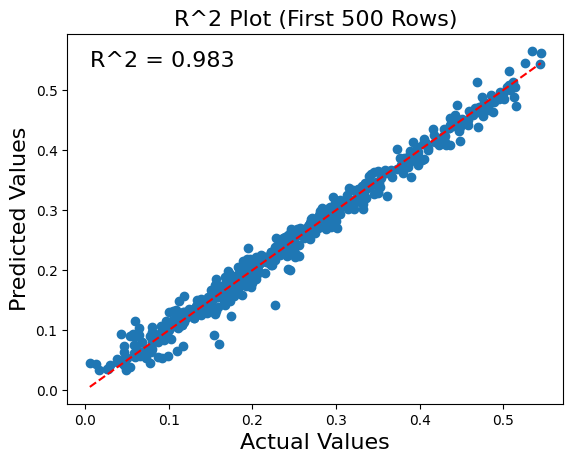

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Slice the test data to include only the first 500 rows
y3_test_subset = y3_test[:500]
X3_test_subset = X3_test[:500]

# Calculate the R^2 score
r2 = r2_score(y3_test_subset, best_model3.predict(X3_test_subset))

# Create a scatter plot of the actual vs predicted values
plt.scatter(y3_test_subset, best_model3.predict(X3_test_subset))

# Add a line for the perfect fit (R^2 = 1)
plt.plot([min(y3_test_subset), max(y3_test_subset)], [min(y3_test_subset), max(y3_test_subset)], 'r--')

# Add the R^2 score to the top left corner of the plot
plt.text(min(y3_test_subset), max(best_model3.predict(X3_test_subset)), f'R^2 = {r2:.3f}',
         fontsize=16, verticalalignment='top', horizontalalignment='left')

# Set the labels and title
plt.xlabel('Actual Values', fontsize=16)
plt.ylabel('Predicted Values', fontsize=16)
plt.title('R^2 Plot (First 500 Rows)', fontsize=16)

# Show the plot
plt.show()


**1D CNN MODEL**

In [ ]:
from tensorflow.keras.layers import InputLayer, Conv1D, Flatten, Dense, GRU

def build_model7(hp):
    model = Sequential()
    model.add(InputLayer((X3_train.shape[1], X3_train.shape[2])))

    # Number of Conv1D layers
    conv_layers = hp.Int('conv_layers', min_value=1, max_value=3, step=1)

    # Add Conv1D layers
    for i in range(conv_layers):
        filters = hp.Int(f'filters_{i}', min_value=32, max_value=128, step=8)
        kernel_size = hp.Int(f'kernel_size_{i}', min_value=2, max_value=5, step=1)
        activation = hp.Choice(f'activation_{i}', values=['relu', 'sigmoid', 'tanh'])
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same'))

    model.add(Flatten())

    # Number of Dense layers
    dense_layers = hp.Int('dense_layers', min_value=1, max_value=3, step=1)

    # Add Dense layers
    for i in range(dense_layers):
        units = hp.Int(f'units_{i}', min_value=32, max_value=128, step=8)
        activation = hp.Choice(f'activation_{i}', values=['relu', 'tanh', 'sigmoid'])
        model.add(Dense(units, activation))

    model.add(Dense(1, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
    return model


# Define the tuner
tuner = RandomSearch(
    build_model7,
    kt.Objective("val_root_mean_squared_error", direction="min"),
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir26',
    project_name='model7_hyperparameter_tuning'
)

# Generate the search space
tuner.search_space_summary()

# Perform the hyperparameter search
tuner.search(X3_train, y3_train, epochs=10, validation_data=(X3_val, y3_val))



Trial 5 Complete [00h 05m 32s]
val_root_mean_squared_error: 0.01819748617708683

Best val_root_mean_squared_error So Far: 0.016645601019263268
Total elapsed time: 00h 25m 48s


In [ ]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hp}")

# Build the best model
best_model13 = tuner.hypermodel.build(best_hp)


model_checkpoint6 = ModelCheckpoint('best_model6.keras', monitor='val_loss', save_best_only=True)

# Train the best model
best_model13.fit(X3_train, y3_train, epochs=100, validation_data=(X3_val, y3_val), callbacks=[early_stopping,model_checkpoint6])

Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x797a455b8610>
Epoch 1/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0017 - root_mean_squared_error: 0.0344 - val_loss: 3.4092e-04 - val_root_mean_squared_error: 0.0185
Epoch 2/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - loss: 3.2318e-04 - root_mean_squared_error: 0.0180 - val_loss: 3.2008e-04 - val_root_mean_squared_error: 0.0179
Epoch 3/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - loss: 3.1269e-04 - root_mean_squared_error: 0.0177 - val_loss: 3.0087e-04 - val_root_mean_squared_error: 0.0173
Epoch 4/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 3.0601e-04 - root_mean_squared_error: 0.0175 - val_loss: 3.1126e-04 - val_root_mean_squared_error: 0.0176
Epoch 5/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 3.0550e-04 - root_mean_squared_error: 0.0175 - val_loss: 2.8530e-04 - val_root_mean_squared_error: 0.0169
Epoch 6/100
7813/7813 ━━━━━━━━━━━━

In [ ]:
best_model13.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 5, 64)               │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 5, 104)              │          33,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 520)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 56)                  │          29,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           1,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 104)                 │           3,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             105 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 204,533 (798.96 KB)

 Trainable params: 68,177 (266.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 136,356 (532.64 KB)

1149/1149 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
RMSE: 0.016716323157377363
MSE: 0.0002794354599018707
MAE: 0.012093405961230097
R-squared: 0.9834221157985946
MAPE: 0.07061824368997144
MASE: 0.4852685225664226
Explained Variance Score: 0.9834509923575471


,Hor Predictions,Hor Actuals
0,0.192746,0.204458
1,0.271425,0.274404
2,0.323406,0.350500
3,0.411807,0.392006
4,0.381541,0.402767
...,...,...
95,0.153408,0.177556
96,0.187947,0.197540
97,0.222603,0.250576
98,0.302805,0.322060


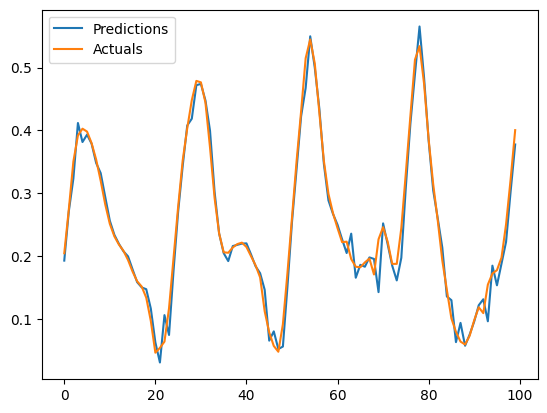

In [ ]:
best_model6 = tf.keras.models.load_model('best_model6.keras')

plot_predictions2(best_model6, X3_test, y3_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


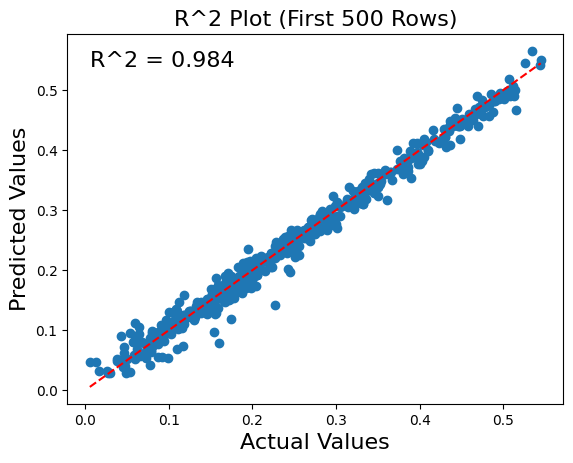

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Slice the test data to include only the first 100 rows
y3_test_subset = y3_test[:500]
X3_test_subset = X3_test[:500]

# Calculate the R^2 score
r2 = r2_score(y3_test_subset, best_model6.predict(X3_test_subset))

# Create a scatter plot of the actual vs predicted values
plt.scatter(y3_test_subset, best_model6.predict(X3_test_subset))

# Add a line for the perfect fit (R^2 = 1)
plt.plot([min(y3_test_subset), max(y3_test_subset)], [min(y3_test_subset), max(y3_test_subset)], 'r--')

# Add the R^2 score to the top left corner of the plot
plt.text(min(y3_test_subset), max(best_model6.predict(X3_test_subset)), f'R^2 = {r2:.3f}',
         fontsize=16, verticalalignment='top', horizontalalignment='left')

# Set the labels and title
plt.xlabel('Actual Values', fontsize=16)
plt.ylabel('Predicted Values', fontsize=16)
plt.title('R^2 Plot (First 500 Rows)', fontsize=16)

# Show the plot
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


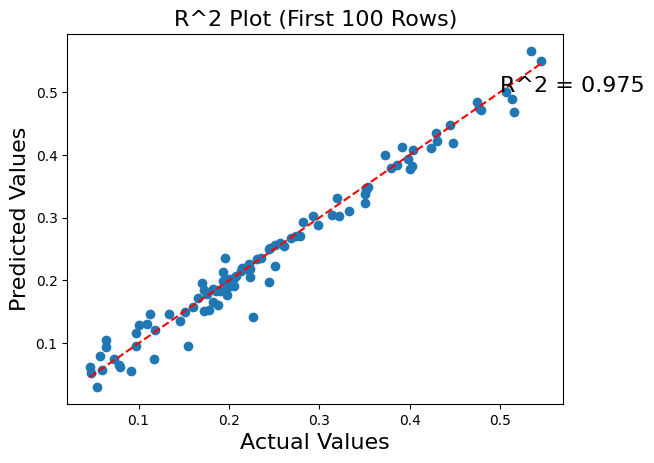

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Slice the test data to include only the first 100 rows
y3_test_subset = y3_test[:100]
X3_test_subset = X3_test[:100]

# Calculate the R^2 score
r2 = r2_score(y3_test_subset, best_model6.predict(X3_test_subset))

# Create a scatter plot of the actual vs predicted values
plt.scatter(y3_test_subset, best_model6.predict(X3_test_subset))

# Add a line for the perfect fit (R^2 = 1)
plt.plot([min(y3_test_subset), max(y3_test_subset)], [min(y3_test_subset), max(y3_test_subset)], 'r--')

# Add the R^2 score to the plot
plt.text(0.5, 0.5, f'R^2 = {r2:.3f}', fontsize=16)

# Set the labels and title
plt.xlabel('Actual Values', fontsize=16)
plt.ylabel('Predicted Values', fontsize=16)
plt.title('R^2 Plot (First 100 Rows)', fontsize=16)

# Show the plot
plt.show()


# **BILSTM**

Trial 5 Complete [00h 54m 50s]
val_root_mean_squared_error: 0.01865025982260704

Best val_root_mean_squared_error So Far: 0.01733660139143467
Total elapsed time: 02h 46m 40s
Epoch 1/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 60s 7ms/step - loss: 0.0052 - root_mean_squared_error: 0.0648 - val_loss: 3.8033e-04 - val_root_mean_squared_error: 0.0195
Epoch 2/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 83s 7ms/step - loss: 3.8278e-04 - root_mean_squared_error: 0.0196 - val_loss: 3.3724e-04 - val_root_mean_squared_error: 0.0184
Epoch 3/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - loss: 3.5122e-04 - root_mean_squared_error: 0.0187 - val_loss: 3.2392e-04 - val_root_mean_squared_error: 0.0180
Epoch 4/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 84s 7ms/step - loss: 3.4060e-04 - root_mean_squared_error: 0.0185 - val_loss: 3.1651e-04 - val_root_mean_squared_error: 0.0178
Epoch 5/100
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - loss: 3.3284e-04 - root_mean_squared_error: 0.0182 - val_loss: 3.2579e-04 - val_root_mean_sq

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional)      │ (None, 112)                 │          25,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 72)                  │           8,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,469 (427.62 KB)

 Trainable params: 36,489 (142.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 72,980 (285.08 KB)

1149/1149 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
RMSE: 0.017414304829343804
MSE: 0.00030325801268930695
MAE: 0.012570229176700731
R-squared: 0.9820088108385487
MAPE: 0.07232852330566603
MASE: 0.5044018666415825
Explained Variance Score: 0.9820088499978782


,Hor Predictions,Hor Actuals
0,0.189258,0.204458
1,0.268908,0.274404
2,0.331774,0.350500
3,0.409913,0.392006
4,0.397848,0.402767
...,...,...
95,0.163154,0.177556
96,0.186464,0.197540
97,0.220783,0.250576
98,0.300550,0.322060


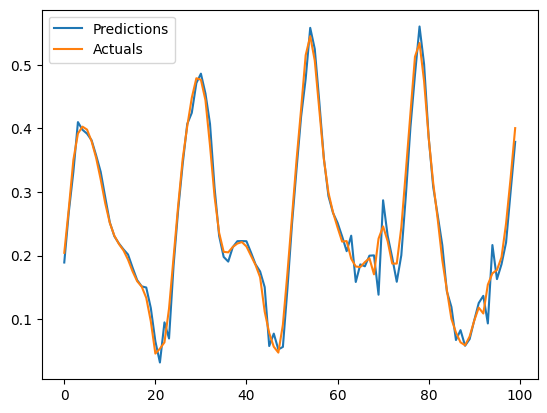

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import kerastuner as kt

def build_bilstm_model(hp):
    model = Sequential()
    model.add(InputLayer((X3_train.shape[1], X3_train.shape[2])))

    # Number of BiLSTM layers
    bilstm_layers = hp.Int('bilstm_layers', min_value=1, max_value=3, step=1)

    # Add BiLSTM layers
    for i in range(bilstm_layers):
        units = hp.Int(f'bilstm_units_{i}', min_value=32, max_value=128, step=8)
        return_sequences = True if i < bilstm_layers - 1 else False  # return sequences for all but last layer
        model.add(Bidirectional(LSTM(units=units, return_sequences=return_sequences)))

    # Number of dense layers
    dense_layers = hp.Int('dense_layers', min_value=1, max_value=3, step=1)

    # Add dense layers
    for i in range(dense_layers):
        units = hp.Int(f'dense_units_{i}', min_value=32, max_value=128, step=8)
        model.add(Dense(units, activation='relu'))

    model.add(Dense(1, activation='linear'))

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
    return model

# Initialize the RandomSearch tuner
tuner = kt.RandomSearch(
    build_bilstm_model,
    kt.Objective("val_root_mean_squared_error", direction="min"),
    max_trials=5,
    directory='my_dir15',
    project_name='bilstm_hyperparameter_tuning'
)

# Search for the best hyperparameters
tuner.search(X3_train, y3_train, epochs=10, validation_data=(X3_val, y3_val))

# Get the best hyperparameters
best_hp2 = tuner.get_best_hyperparameters(num_trials=1)[0]

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint('best_model91.keras', monitor='val_loss', save_best_only=True)

# Build the best model based on the best hyperparameters
best_model91 = tuner.hypermodel.build(best_hp2)

# Train the best model with early stopping and model checkpoint callbacks
history = best_model91.fit(X3_train, y3_train, epochs=100, validation_data=(X3_val, y3_val), callbacks=[early_stopping, model_checkpoint])

best_model91.summary()

best_model81 = tf.keras.models.load_model('best_model91.keras')

plot_predictions2(best_model81, X3_test, y3_test)


1149/1149 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


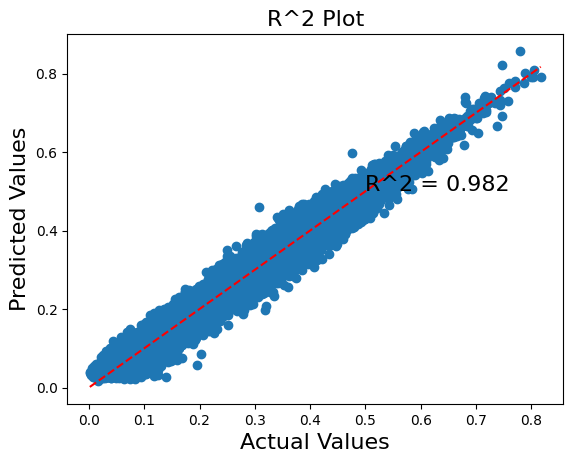

In [ ]:
import matplotlib.pyplot as plt

# Calculate the R^2 score
r2 = r2_score(y3_test, best_model81.predict(X3_test))

# Create a scatter plot of the actual vs predicted values
plt.scatter(y3_test, best_model81.predict(X3_test))

# Add a line for the perfect fit (R^2 = 1)
plt.plot([min(y3_test), max(y3_test)], [min(y3_test), max(y3_test)], 'r--')

# Add the R^2 score to the plot
plt.text(0.5, 0.5, f'R^2 = {r2:.3f}', fontsize=16)

# Set the labels and title
plt.xlabel('Actual Values', fontsize=16)
plt.ylabel('Predicted Values', fontsize=16)
plt.title('R^2 Plot', fontsize=16)

# Show the plot
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


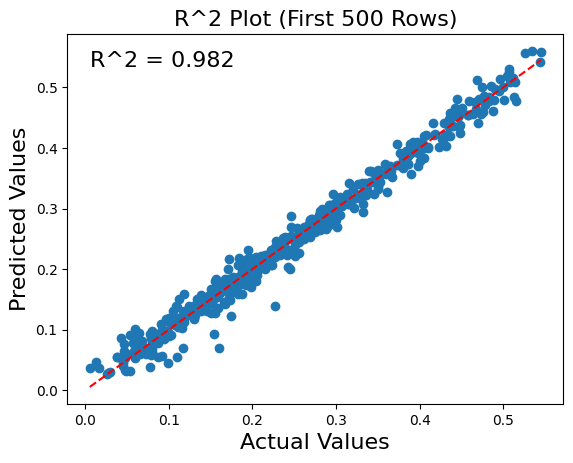

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Slice the test data to include only the first 100 rows
y3_test_subset = y3_test[:500]
X3_test_subset = X3_test[:500]

# Calculate the R^2 score
r2 = r2_score(y3_test_subset, best_model81.predict(X3_test_subset))

# Create a scatter plot of the actual vs predicted values
plt.scatter(y3_test_subset, best_model81.predict(X3_test_subset))

# Add a line for the perfect fit (R^2 = 1)
plt.plot([min(y3_test_subset), max(y3_test_subset)], [min(y3_test_subset), max(y3_test_subset)], 'r--')

# Add the R^2 score to the top left corner of the plot
plt.text(min(y3_test_subset), max(best_model81.predict(X3_test_subset)), f'R^2 = {r2:.3f}',
         fontsize=16, verticalalignment='top', horizontalalignment='left')

# Set the labels and title
plt.xlabel('Actual Values', fontsize=16)
plt.ylabel('Predicted Values', fontsize=16)
plt.title('R^2 Plot (First 500 Rows)', fontsize=16)

# Show the plot
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


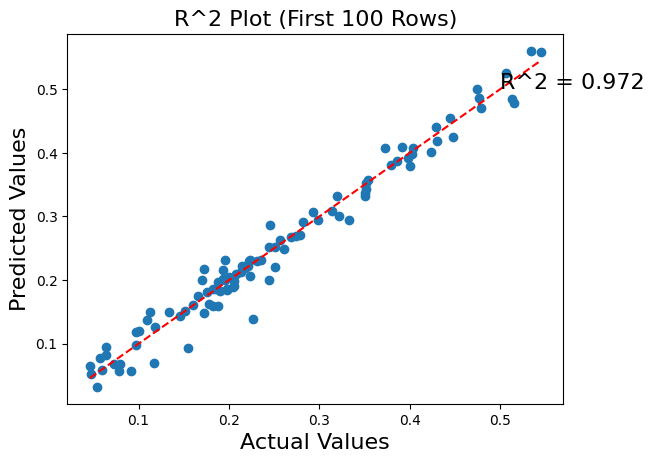

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Slice the test data to include only the first 100 rows
y3_test_subset = y3_test[:100]
X3_test_subset = X3_test[:100]

# Calculate the R^2 score
r2 = r2_score(y3_test_subset, best_model81.predict(X3_test_subset))

# Create a scatter plot of the actual vs predicted values
plt.scatter(y3_test_subset, best_model81.predict(X3_test_subset))

# Add a line for the perfect fit (R^2 = 1)
plt.plot([min(y3_test_subset), max(y3_test_subset)], [min(y3_test_subset), max(y3_test_subset)], 'r--')

# Add the R^2 score to the plot
plt.text(0.5, 0.5, f'R^2 = {r2:.3f}', fontsize=16)

# Set the labels and title
plt.xlabel('Actual Values', fontsize=16)
plt.ylabel('Predicted Values', fontsize=16)
plt.title('R^2 Plot (First 100 Rows)', fontsize=16)

# Show the plot
plt.show()
